In [1]:
import sys
sys.path.append('..')
import gdspy
import numpy as np
from importlib import reload
#import libraries.conformal_mapping as cm
#import libraries.general_design_functions as gdf
#import libraries.general_sample_creator as creator
#from  ..libraries import general_design_functions as gdf
#fr
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator

In [2]:
tl_core = 20
tl_gap = 12
tl_ground = 10

resonator_core = 8
resonator_gap = 7
resonator_ground = 16

pad_offset = 1000
pad_element_offset = 1000

coupler_start = pad_offset + pad_element_offset
coupler_delta = 500
coupler_length = 300
num_couplers = 1

# Transmission line with resonator (failed version)

In [9]:
reload(gdspy)
reload(creator)
reload(elements)

layers_configuration = {
    'total':0,
    'restricted area':10,
    'for removing':100,
    'JJs':1,
    'air bridges':2,
    'air bridge pads':3,
    'vertical gridlines':15,
    'horizontal gridlines':16,
     'inverted':20
}
sample = creator.Sample('4_qubits',layers_configuration)

#specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size=4.7e3
sample.chip_geometry.sample_horizontal_size=9.7e3

central_line_y = sample.chip_geometry.sample_vertical_size/2

ChichkovAB = elements.AirBridge(width=15, 
                                length=60, 
                                padsize=30, 
                                min_spacing = 30,
                                layer_configuration=sample.layer_configuration)

chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads)
sample.add(chip_edge_ground)

grid_ground = elements.GridGround(sample.chip_geometry, sample.layer_configuration, sample.objects, 
                                  width=4, period=500)
sample.add(grid_ground)

# 1. Create contact pads:

p1 = elements.Pad('p1', (pad_offset,  central_line_y), np.pi, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
p2 = elements.Pad('p2', (sample.chip_geometry.sample_horizontal_size-pad_offset,  central_line_y), 
                  0, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
sample.add(p1)
sample.add(p2)

def draw_single_resonator(coupler_start_x, coupler_start_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width,
                         closed_end_meander_length, open_length):
    # 2. Create main copler:
    total_length=0

    main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start_x, central_line_y), 
                                                                (coupler_start_x+coupler_length, central_line_y)],
                                       [resonator_core, resonator_ground, tl_core],[resonator_gap, resonator_gap, tl_gap, tl_gap],
                                       tl_ground, sample.layer_configuration, r=100)
    sample.add(main_coupler)
    total_length = total_length + coupler_length

    # 3. Create fanout to create closed end of resonator
    fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1, 3])

    # 4. 
    g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width, grounding_between = [(2,3)])

    # 6. Create closed meander of resonator
    closed_end_meander = sample.connect_meander(name='closed end', o1=fanout_for_closed_end, port1='up',
                                                meander_length=closed_end_meander_length,
                                                length_left =150,
                                                length_right =300,
                                                first_step_orientation ='left',
                                                meander_orientation = 0,meander_type='round')
    print(closed_end_meander.length)
#                                                 end_point=(1500,1500),
#                                                end_orientation=0)
    total_length = total_length + closed_end_meander.length
    # 7. Create grounding of resonator
# #     resonator_ground_ = sample.ground(o=closed_end_meander, port='port2', name='resonator ground', grounding_width=30, grounding_between = [(0,2)])
   
#     # 8. Create fanout to create open end of resonator
#     fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 3])

#     # 9. 
#     g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1)])

#     # 10. Create open end of resonator
#     open_end = elements.OpenEnd(name='open end',position=(fanout_for_open_end.get_terminals()['down'].position[0],
#                                                                    fanout_for_open_end.get_terminals()['down'].position[1]-open_length),
#                                          w=[resonator_core],
#                                          s=[resonator_gap, resonator_gap],
#                                          g=tl_ground,
#                                          orientation=-np.pi/2,
#                                          layer_configuration=sample.layer_configuration,
#                                          h1=20,
#                                           h2=10,
#                                          )
#     sample.add(open_end)
#     # 11. Connect open end with the coupler part of the resonator
#     open_end_resonator = sample.connect_cpw(fanout_for_open_end,open_end,'down','wide',name='right open end',points=[])
#     total_length = total_length + open_end_resonator.length
    res_params = total_length#,open_end_resonator.z0,open_end_resonator.cl)
    g2=0
    return g1, g2, res_params,closed_end_meander

In [10]:
g1, g2,res_params,meander = draw_single_resonator(coupler_start, central_line_y, coupler_length,
                        resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
                        closed_end_meander_length=250, open_length=1000)
# g3, g4 = draw_single_resonator(coupler_start+1000, central_line_y, coupler_length,
#                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
#                         closed_end_meander_length=2500, open_length=1100)
# 5. Create left part of transmission line
# left_TL = sample.connect_cpw(o1=p1, o2=g1, port1='port', port2='narrow', name='left TL', points=[])
# 9. Create middle part of transmission line
# middle_TL = sample.connect_cpw(o1=g3, o2=g2, port1='narrow', port2='narrow', name='middle TL', points=[])
# 9. Create left part of transmission line
# right_TL = sample.connect_cpw(o1=p2, o2=g2, port1='port', port2='narrow', name='right TL', points=[])

Meander
meander is too small, N=0
[(1989.0, 2299.0), (1989.0, 2249.0), (2139.0, 2249.0), (2207.0, 2249.0)]
250.83185307179588
250.83185307179588


In [11]:
design = sample.draw_design()
sample.write_to_gds()
sample.watch()

Gds file has been writen here:  C:\Python\Github\QCreator\example_notebooks\4_qubits.gds


In [12]:
def search_for_resonators(f,delta):
    res_modes = []
    qs=f/delta*2
    min_freq=4e9
    max_freq=10e9
    min_Q=1e3
    max_Q=100e3
    for mode_id in range(len(qs)):
#         print(qs[mode_id])
#         print(f[mode_id])
        if min_Q<=qs[mode_id]<=max_Q and min_freq<=f[mode_id]/2/np.pi<=max_freq:
            res_modes.append(mode_id)
    print(f[res_modes]/(2*np.pi)/1e9, delta[res_modes]/1e6, qs[res_modes])
    return f[res_modes]/(2*np.pi)/1e9, delta[res_modes]/1e6, qs[res_modes]

In [16]:
%%time
sys, connections, elements_ = sample.get_tls()
f, delta, modes = sys.get_modes()
f[:10]/(2*np.pi)/1e9, delta[:10]/1e6,f[:10]/delta[:10]/2 
# search_for_resonators(f,delta)

Wall time: 413 ms


(array([ 7.80908273,  8.08398634, 15.9885595 , 19.61257439, 20.16517046,
        24.25191625, 24.59531461, 26.29920764, 26.3684321 , 31.12777179]),
 array([ 7.30791791e+04,  7.04520780e-01,  7.04234789e+04,  1.17396573e+05,
         7.45943853e+04,  6.19778668e+00,  2.38444996e+05,  1.47253965e+04,
         1.40476199e+04, -1.01863457e+05]),
 array([ 3.35703784e-01,  3.60480384e+04,  7.13249925e-01,  5.24842575e-01,
         8.49269702e-01,  1.22930404e+04,  3.24051505e-01,  5.61080970e+00,
         5.89700414e+00, -9.60018268e-01]))

In [19]:
f[0]/(2*np.pi) / 1e9, (f[0]/(2*np.pi)) / (delta[0]/(2*np.pi) * 2)

(7.713980526131971, 39598.561727055116)

In [20]:
%%time
sys, connections, elements_ = sample.get_tls()
f, delta, modes = sys.get_modes()
# f[:10]/(2*np.pi)/1e9, delta[:10]/1e6,f[:10]/delta[:10]/2 
search_for_resonators(f,delta)

[7.67501764] [0.54469301] [44266.73081401]
Wall time: 913 ms


(array([7.67501764]), array([0.54469301]), array([44266.73081401]))

In [38]:
res_params

(3599.8739999580002, 56.784268722636455, 1.4656184980033523e-16)

In [25]:
res_params[0]+40e-15/res_params[-1]

3872.79631947357

..\QCreator\general_sample_creator.py:388: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  s.append(np.linalg.lstsq(m, boundary)[0][a2[0]])


Wall time: 27.1 s


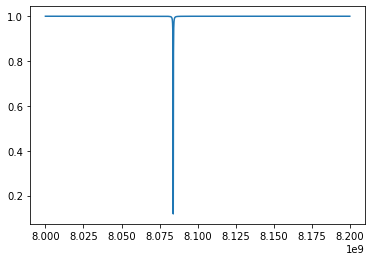

In [20]:
%%time
f_ = np.linspace(8e9, 8.2e9, 5001)
# s11 = sample.get_s21('p1', 'p1', f_)
s21 = sample.get_s21('p1', 'p2', f_)
from matplotlib import pyplot as plt
# plt.plot(f_, np.abs(s11))
plt.plot(f_, np.abs(s21))

In [24]:
import resonator_tools
from resonator_tools.circuit import notch_port, reflection_port

ModuleNotFoundError: No module named 'resonator_tools'

In [32]:
fitter = notch_port(f_data=f_, z_data_raw=s21)

In [33]:
fitter.autofit()

E:\py38\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 200.
  warnings.warn(errors[info][0], RuntimeWarning)


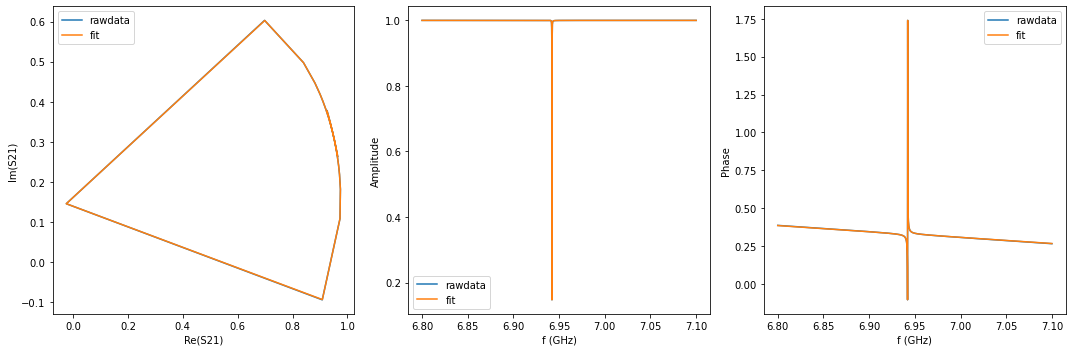

In [34]:
fitter.plotall()

In [35]:
fitter.fitresults

{'Qi_dia_corr': -61786634147.744675,
 'Qi_no_corr': -563357774.5257353,
 'absQc': 53844.26363585252,
 'Qc_dia_corr': 53849.36348997791,
 'Ql': 53849.41042175394,
 'fr': 6942189472.323195,
 'theta0': -3.127829986616499,
 'phi0': 0.013762806859149091,
 'chi_square': 4.4929781902268117e-07,
 'delay': 6.327872346361034e-11,
 'a': 0.9997246446119027,
 'alpha': 3.090242741026523}

In [4]:
def draw_double_resonator(coupler_start_x, coupler_start_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width,
                         closed_end_meander_length1, open_length1, closed_end_meander_length2, open_length2):
    # 2. Create main copler:

    main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start, central_line_y), 
                                                                (coupler_start+coupler_length, central_line_y)],
                                       [resonator_core, resonator_ground, tl_core, resonator_ground, resonator_core],
                                       [resonator_gap, resonator_gap, tl_gap, tl_gap, resonator_gap, resonator_gap],
                                       tl_ground, sample.layer_configuration, r=100)
    sample.add(main_coupler)

    # 3. Create fanout to create closed end of resonator
    fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1, 4])

    # 4. 
    g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width, grounding_between = [(0,1), (3,4)])

    # 6. Create closed meander of resonator
    closed_end_meander1 = sample.connect_meander(name='closed end 1', o1=fanout_for_closed_end, port1='up',
                                                meander_length=closed_end_meander_length1,restricted_scale=400, constant_scale=900, radius=0)
    
    closed_end_meander2 = sample.connect_meander(name='closed end 2', o1=fanout_for_closed_end, port1='down',
                                                meander_length=closed_end_meander_length2,restricted_scale=400, constant_scale=900, radius=0)

    # 7. Create fanout to create closed enfd of resonator
    fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 4])

    # 8. 
    g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1), (3,4)])

    # 10. Create closed meander of resonator
    open_end_resonator1 = elements.CPW(name='open end resonator 1', points=[fanout_for_open_end.get_terminals()['down'].position, 
                                                                         (fanout_for_open_end.get_terminals()['down'].position[0],
                                                                          fanout_for_open_end.get_terminals()['down'].position[1]-open_length1)],
                                      w=fanout_for_open_end.get_terminals()['down'].w, s=fanout_for_open_end.get_terminals()['down'].s,
                                      g=fanout_for_open_end.get_terminals()['down'].g, layer_configuration=sample.layer_configuration, r=25)
    sample.add(open_end_resonator1)
    sample.connections.append(((fanout_for_open_end, 'down', 0), (open_end_resonator1, 'port1', 0)))
    
    open_end_resonator2 = elements.CPW(name='open end resonator 2', points=[fanout_for_open_end.get_terminals()['up'].position, 
                                                                         (fanout_for_open_end.get_terminals()['up'].position[0],
                                                                          fanout_for_open_end.get_terminals()['up'].position[1]+open_length2)],
                                      w=fanout_for_open_end.get_terminals()['up'].w, s=fanout_for_open_end.get_terminals()['up'].s,
                                      g=fanout_for_open_end.get_terminals()['up'].g, layer_configuration=sample.layer_configuration, r=25)
    sample.add(open_end_resonator2)
    sample.connections.append(((fanout_for_open_end, 'up', 0), (open_end_resonator2, 'port1', 0)))

    # 11. Create grounding of resonator
    resonator_ground_1 = sample.ground(o=closed_end_meander1, port='port2', name='resonator ground 1', grounding_width=30, grounding_between = [(0,2)])
    resonator_ground_2 = sample.ground(o=closed_end_meander2, port='port2', name='resonator ground 2', grounding_width=30, grounding_between = [(0,2)])
    
    return g1, g2